In [198]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
from sasc.modules.fmri_module import convert_module_num_to_voxel_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230504'
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
story_mapping = {
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=3": 'GenStory2_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=4": 'GenStory6_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=1": 'GenStory4_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=2": 'GenStory5_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=4": 'GenStory3_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=1": 'GenStory1_resps.npy',
}

In [ ]:
STORIES_DIR = join(sasc.config.RESULTS_DIR, 'pilot_v1')
story_names = story_mapping.keys() # os.listdir(STORIES_DIR)

story_data = defaultdict(list)
for story_name in story_names:
    story_data['timing'].append(pd.read_csv(join(STORIES_DIR, story_name, 'timings_processed.csv')))
    story_data['story_name_original'].append(story_name)
    story_data['story_name_new'].append(story_mapping[story_name])
    story_data['story_text'].append(open(join(STORIES_DIR, story_name, 'story.txt'), 'r').read())    
    story_data['rows'].append(pd.read_csv(join(STORIES_DIR, story_name, 'rows.csv')))

    print(story_name, story_data['timing'][-1]['time_running'].round(1).max())

uts02_pilot_gpt4_mar28___ver=v4_noun___seed=3 784.0
uts02_pilot_gpt4_mar28___ver=v5_noun___seed=4 961.0
uts02_pilot_gpt4_mar28___ver=v5_noun___seed=1 830.2
uts02_pilot_gpt4_mar28___ver=v5_noun___seed=2 834.2
uts02_pilot_gpt4_mar28___ver=v4_noun___seed=4 663.8
uts02_pilot_gpt4_mar28___ver=v4_noun___seed=1 890.3


# look at single story

/tmp/ipykernel_152493/1068379883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)


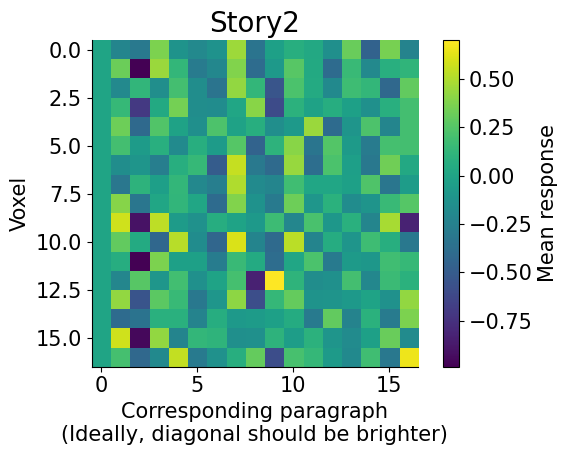

/tmp/ipykernel_152493/1068379883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)


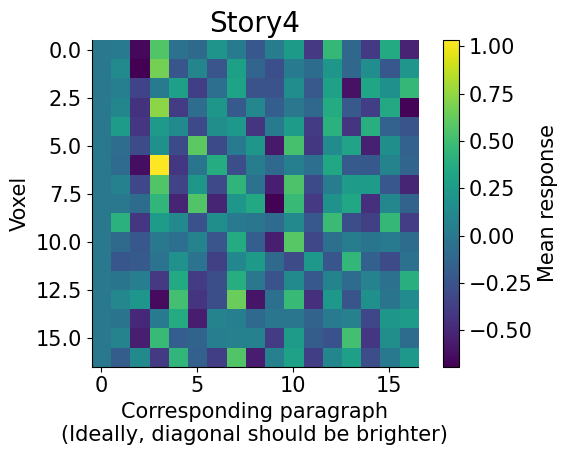

/tmp/ipykernel_152493/1068379883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)


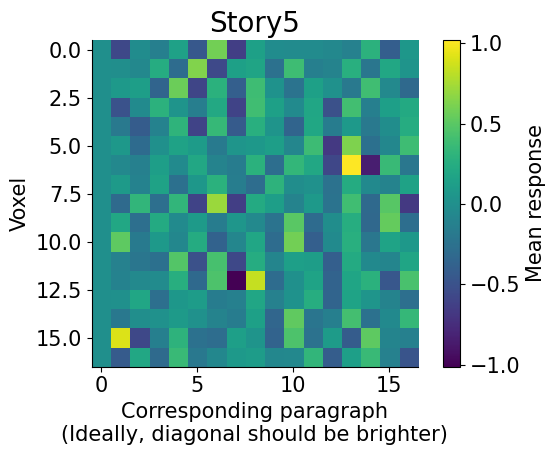

/tmp/ipykernel_152493/1068379883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)


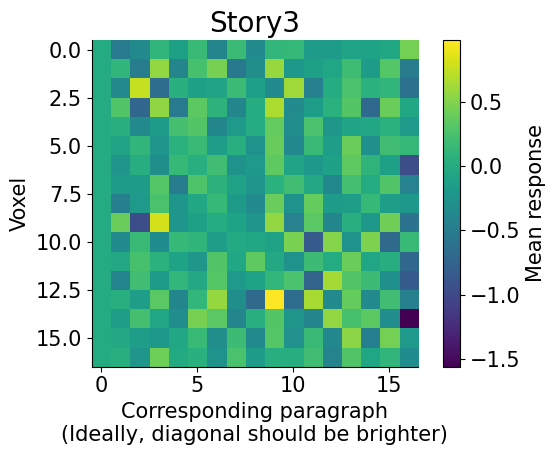

/tmp/ipykernel_152493/1068379883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)


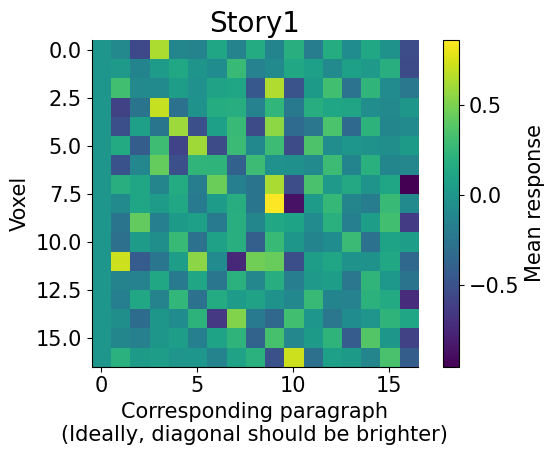

In [ ]:
for story_num in [0, 1, 2, 3, 4, 5]:
    rows = story_data['rows'][story_num]
    rw = rows[['expl', 'module_num', 'top_explanation_init_strs', 'subject', 'fmri_test_corr', 'top_score_synthetic', 'roi_anat', 'roi_func']]
    rw['voxel_num'] = rw.apply(lambda row: convert_module_num_to_voxel_num(row['module_num'], row['subject']), axis=1)
    paragraphs = story_data['story_text'][story_num].split('\n\n')
    assert len(paragraphs) == len(rw), (len(paragraphs), len(rw))

    # get start times, end times for each paragraph
    timing = story_data['timing'][story_num]
    idx = 0
    start_times = []
    end_times = []
    for para in paragraphs:
        words = para.split()
        start_times.append(timing['time_running'][idx])
        for word in words:
            assert timing['word'][idx] == word, (idx, timing['word'][idx], word)
            idx += 1
            if idx == len(timing):
                break
        end_times.append(timing['time_running'][idx - 1])
    start_times = (np.array(start_times) // 2).astype(int)
    end_times = (np.array(end_times) // 2).astype(int)

    # get resp
    resp = resps_dict[story_data['story_name_new'][story_num]].T # (voxels, time)
    resp = resp[rw['voxel_num'].values]

    mat = np.zeros((resp.shape[0], len(start_times)))
    for i in range(len(start_times)):
        mat[:, i] = resp[:, start_times[i]:end_times[i]].mean(axis=1)

    mat[:, 0] = 0


    # mat = softmax(mat, axis=0)
    plt.imshow(mat)
    plt.colorbar(label='Mean response')
    plt.xlabel('Corresponding paragraph\n(Ideally, diagonal should be brighter)')
    plt.ylabel('Voxel')
    plt.title(f"{story_data['story_name_new'][story_num][3:-10]}")
    plt.show()

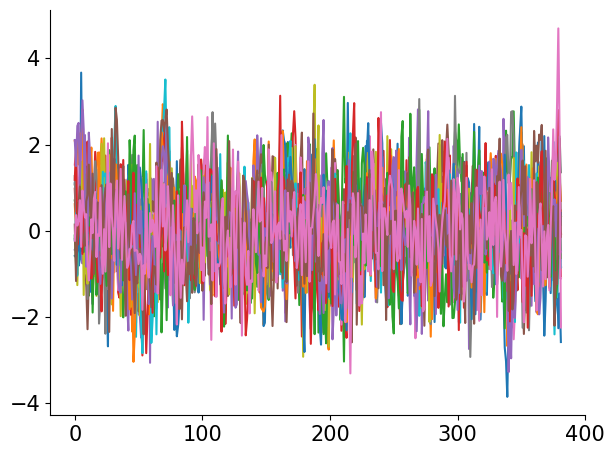

In [153]:
for i in range(resp.shape[0]):
    plt.plot(resp[i])